<a href="https://colab.research.google.com/gist/rfjames/548af578affb08e2f5def8d5389724d4/scrabble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install autodistill_sam3 "inference-gpu[sam3]" autodistill roboflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 61.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [3]:
import os

os.environ["ROBOFLOW_API_KEY"] = ""

In [231]:
import numpy as np
import supervision as sv
import cv2
import string

from autodistill_sam3 import SegmentAnything3
from inference.models.perception_encoder import PerceptionEncoder
from autodistill.detection import CaptionOntology

pe = PerceptionEncoder()
model = SegmentAnything3(
    ontology=CaptionOntology(
        {
            "board": "board"
        }
    )
)

image = cv2.imread("word.jpeg")

board_detections = model.predict(image)
board_xyxy = board_detections.xyxy[0]
# TODO: get the biggest detection by area
image = image[int(board_xyxy[1]) : int(board_xyxy[3]), int(board_xyxy[0]) : int(board_xyxy[2])]

Creating PE-CLIP model
Missing keys for loading model: []
Unexpected keys for loading model: []


In [298]:
model.ontology = CaptionOntology(
    {
        "white tile": "white tile"
    }
)

detections = model.predict(image)

# filter small detections by area
w = detections.xyxy[:, 2] - detections.xyxy[:, 0]
h = detections.xyxy[:, 3] - detections.xyxy[:, 1]
detections = detections[(w > 15)]

x0 = detections.xyxy[:, 0].min()
y0 = detections.xyxy[:, 1].min()
x1 = detections.xyxy[:, 2].max()
y1 = detections.xyxy[:, 3].max()

image = image[int(y0) : int(y1), int(x0) : int(x1)]

detections = model.predict(image)

# filter small detections by area
w = detections.xyxy[:, 2] - detections.xyxy[:, 0]
h = detections.xyxy[:, 3] - detections.xyxy[:, 1]
detections = detections[(w > 25) & (h > 25)]

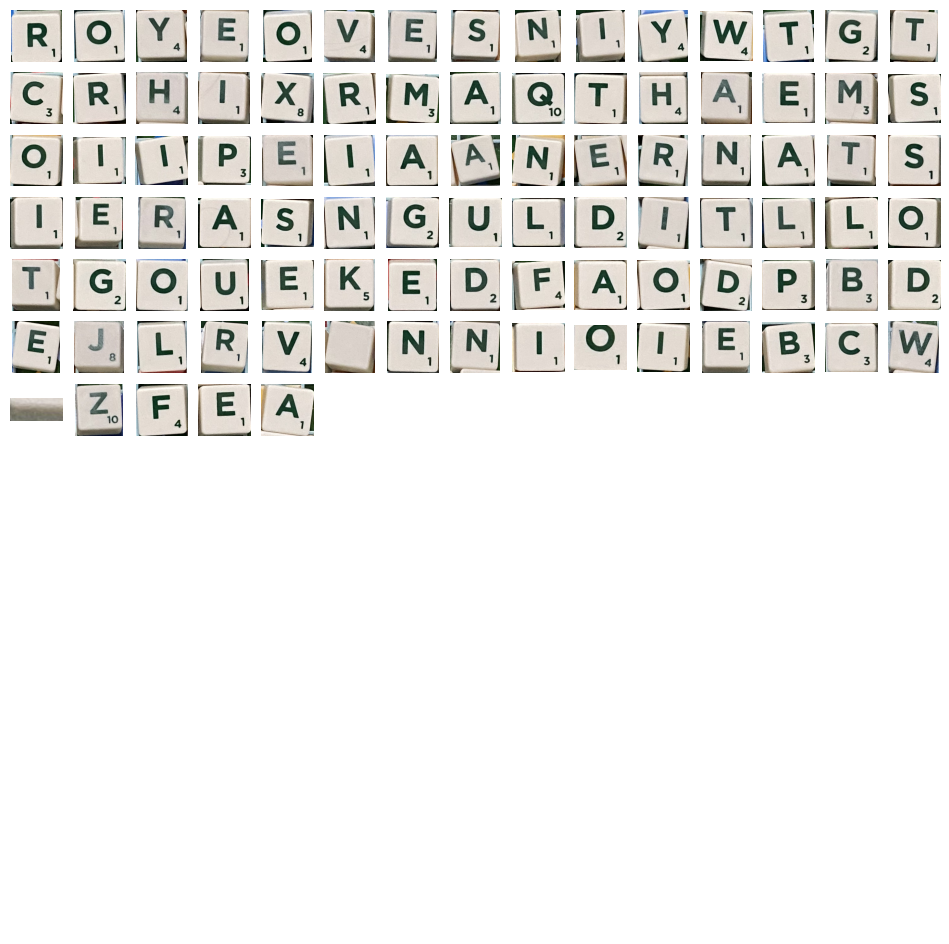

In [299]:
# create text embeddings for A-Z + special tiles
all_letters = list(string.ascii_lowercase)
special = [
    # "double letter",
    # "triple letter",
    # "double word",
    # "triple word",
    "blank tile",
]
text_embeddings = [
    pe.embed_text("letter " + letter.upper()) for letter in all_letters
] + [pe.embed_text(s) for s in special]

all_letters = all_letters + special

# crop each letter
crops = [
    image[int(y1) : int(y2), int(x1) : int(x2)] for (x1, y1, x2, y2) in detections.xyxy
]
sv.plot_images_grid(crops, grid_size=(15, 15))
# embed each crop
embeddings = [pe.embed_image(crop)[0] for crop in crops]
found_letters = []
letter_counts = {letter: 0 for letter in all_letters}

# find most similar text embedding to each image crop embedding
for embedding in embeddings:
    similarity = [
        np.dot(embedding, text_embedding[0])
        / (np.linalg.norm(embedding) * np.linalg.norm(text_embedding[0]))
        for text_embedding in text_embeddings
    ]
    best_idx = np.argmax(similarity)
    best_letter = all_letters[best_idx]
    found_letters.append(best_letter)
    letter_counts[best_letter] += 1

Detected letters and counts: {'a': 8, 'b': 2, 'c': 2, 'd': 4, 'e': 11, 'f': 2, 'g': 3, 'h': 2, 'i': 9, 'j': 1, 'k': 1, 'l': 4, 'm': 2, 'n': 6, 'o': 7, 'p': 2, 'q': 1, 'r': 6, 's': 4, 't': 6, 'u': 2, 'v': 2, 'w': 2, 'x': 1, 'y': 2, 'z': 1, 'blank tile': 2}
Number of scrabble tiles detected: 95


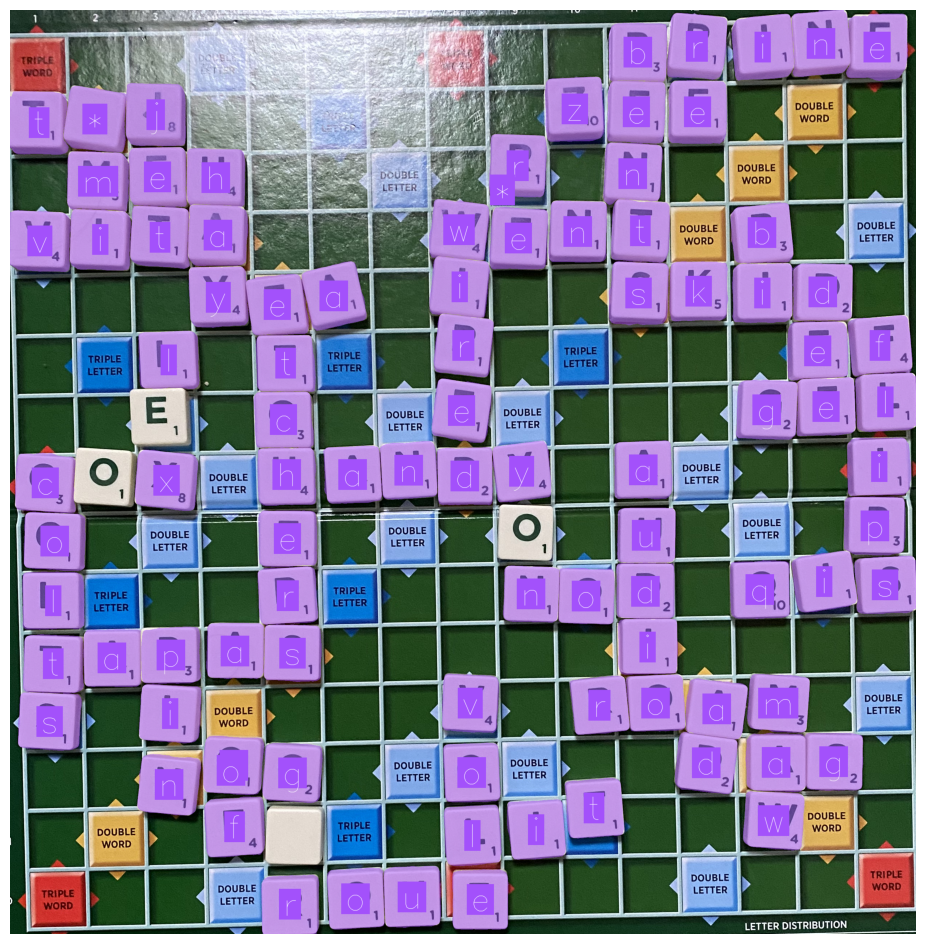

In [300]:
print("Detected letters and counts:", letter_counts)
print("Number of scrabble tiles detected:", len(detections))

detections.data = {"letters": found_letters}

# detections = detections.with_nmm(threshold=1)

annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER, text_scale=3)
annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=[i if i != "blank tile" else "*" for i in found_letters]
)

sv.plot_image(annotated_frame)


In [354]:
from collections import defaultdict
import math
image_width = image.shape[1]
tile_width = image_width / 15

def get_words_on_axes(axis, distance=image_width/15):
  if axis == "x":
    axis = 1
    points = detections.get_anchors_coordinates(anchor=sv.Position.CENTER)
  else:
    axis = 0
    points = detections.get_anchors_coordinates(anchor=sv.Position.CENTER)

  points2detections = defaultdict(list)
  for point, detection in zip(points, detections):
      ps = tuple([int(point[0]), int(point[1])])
      points2detections[ps].append(detection)

  rows = [[]]
  lx, ly = 0, 0

  indices_x = points[:, int(not(bool(axis)))].argsort()
  points = points[indices_x]

  for x, y in points:
    if lx or ly:
      point = [int(x), int(y)]
      if (
          axis == 1 and x > lx - ((distance / 25) * 4) and x < lx + ((distance / 25) * 4)  or
          axis == 0 and y > ly - ((distance / 25) * 4) and y < ly + ((distance / 25) * 4)
      ):
        rows[-1].append(point)
      else:
        rows.append([point])
    else:
      lx, ly = x, y
      rows[-1].append([int(lx), int(ly)])

    lx, ly = x, y

  axes_words = []

  grid_chr = np.empty((len(rows), len(rows)), dtype=object)
  grid_chr[:] = "-"

  for row_id, row in enumerate(rows):
    indices_y = np.array(row)[:, axis].argsort()
    row = np.array(row)[indices_y]
    last_x = -1
    current_word = ""
    for idx, item in enumerate(row):
      current_letter = points2detections[tuple(item)][0][5]["letters"][0]
      pos_since_line_start = math.ceil(item[axis] / tile_width)
      if idx == 0 and pos_since_line_start == 1:
        pos_since_line_start = 0
      if current_letter in special and current_letter != "blank tile":
        current_letter = ""
      if current_letter == "blank tile":
        current_letter = "*"
      grid_chr[row_id][int(pos_since_line_start)] = current_letter

      last_x = item[axis]

  rows_to_remove = []

  iters = 3

  for i in range(0, iters):
    for row_id, row in enumerate(grid_chr):
      blank_cell_count = np.equal(row, "-").sum()
      if blank_cell_count == len(row) - 1:
        # move any chars up to above row
        for pos, item in enumerate(grid_chr[row_id]):
          if item != "-":
            grid_chr[row_id - 1][pos] = item
            grid_chr[row_id][pos] = "-"

    # remove rows
    for row_id in rows_to_remove:
      grid_chr = np.delete(grid_chr, row_id, axis=0)

    # remove all blank rows
    grid_chr = grid_chr[~np.all(grid_chr == '-', axis=1)]
    # remove blank columns
    grid_chr = grid_chr[:, ~np.all(grid_chr == '-', axis=0)]

  return grid_chr

# x_words = get_words_on_axes("x")
grid_chr = get_words_on_axes("y")
# print("VERTICAL WORDS:", x_words)
# print("HORIZONTAL WORDS:", grid_chr)

score = {"a": 1, "c": 3, "b": 3, "e": 1, "d": 2, "g": 2,
         "f": 4, "i": 1, "h": 4, "k": 5, "j": 8, "m": 3,
         "l": 1, "o": 1, "n": 1, "q": 10, "p": 3, "s": 1,
         "r": 1, "u": 1, "t": 1, "w": 4, "v": 4, "y": 4,
         "x": 8, "z": 10, "-": 0, "*": 0}

grid_transposed_with_score = []

for row in grid_chr:
  r = []
  for item in row:
    r.append(score[item])
  grid_transposed_with_score.append(r)

# for row in grid_transposed_with_score:
#   print(row)

words = []

CTRL_CHR = "-"

for row_id, row in enumerate(grid_chr):
  cur_word = ""
  for chr_id, chr in enumerate(row):
    if chr != CTRL_CHR:
      cur_word += chr
      if chr_id == len(row) - 1:
        words.append(cur_word)
        cur_word = ""
    else:
      # if len(cur_word) > 1:
      words.append(cur_word)
      cur_word = ""

flipped = np.rot90(grid_chr)

for row_id, row in enumerate(flipped):
  cur_word = ""
  for chr_id, chr in enumerate(row):
    if chr != CTRL_CHR:
      cur_word += chr
      if chr_id == len(row) - 1:
        words.append(cur_word)
        cur_word = ""
    else:
      # if len(cur_word) > 1:
      words.append(cur_word)
      cur_word = ""

# flip grid_chr so cols are rows
# flipped = np.flipud(grid_chr)

print("BOARD:\n")

for row in grid_chr:
  print(" ".join(row))

words = [w for w in words if w and len(w) > 1]
unique_words = set(words)
longest_word = max([len(i) for i in unique_words])
longest_words = ", ".join([i for i in unique_words if len(i) == longest_word])
shortest_word = min([len(i) for i in unique_words])
shortest_words = ", ".join([i for i in unique_words if len(i) == shortest_word])

print("\nSTATS:\n")
print("# of unique words:", len(unique_words))
print("len() of longest words:", longest_word)
print("longest word(s):", longest_words)
print()
print("len() of shortest words:", shortest_word)
print("shortest word(s):", shortest_words)

BOARD:

- - - - - - - - - - b r i n e
t * j - - - - - - z e e - - -
- m e h - - - - r - n - - - -
v i t a - - - w e n t - b - -
- - - y e a - i - - s k i d -
- - l - t - - r - - - - - e f
- - - - c - - e - - - - g e l
c - x - h a n d y - a - - - i
o - - - e - - - - - u - - - p
l - - - r - - - n o d - q i s
t a p a s - - - - - i - - - -
s - i - - - - v - r o a m - -
- - n o g - - o - t - d a g -
- - - f - - - l i - - - w - -
- - - - r o u e - - - - - - -

STATS:

# of unique words: 37
len() of longest words: 7
longest word(s): etchers

len() of shortest words: 2
shortest word(s): li, ef, of, rt, bi, re, ad
